Bước 1: Nhập dữ liệu và tiền xử lý ảnh

In [8]:
# Kết nối với gg drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tăng cường dữ liệu cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# Tăng cường dữ liệu cho tập validation và test (chỉ rescale)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_path = '/content/drive/MyDrive/Code/DogImages/'
# Tạo các generators cho từng tập dữ liệu
train_generator = train_datagen.flow_from_directory(
    base_path + 'Train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
valid_generator = valid_datagen.flow_from_directory(
    base_path + 'Validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    base_path + 'Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 496 images belonging to 5 classes.
Found 101 images belonging to 5 classes.
Found 98 images belonging to 5 classes.


Bước 2: Xây dựng và huấn luyện mô hình CNN

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Load VGG16 với trọng số tiền huấn luyện từ ImageNet, bỏ phần top (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Đóng băng tất cả các lớp của base_model
base_model.trainable = False

# Tạo mô hình mới với các lớp học thêm và sử dụng L2 Regularization
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(5, activation='softmax')  # 5 lớp đầu ra cho 5 giống chó
])

# Cài đặt trình tối ưu với learning rate thấp
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Thiết lập callback
checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/Code/DogImages/best_model.keras', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình với các callback
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=40,
    callbacks=[checkpointer, reduce_lr, early_stopping],
    verbose=1
)
# Sau khi huấn luyện xong, mở lại các lớp của VGG16 và huấn luyện lại
base_model.trainable = True

# Giới hạn việc huấn luyện các lớp của VGG16 chỉ với lớp cuối cùng (dưới cùng của mô hình)
fine_tune_at = 10  # Số lớp VGG16 mà bạn muốn mở lại

# Đóng băng các lớp VGG16 phía trước
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Cập nhật lại mô hình và huấn luyện lại với learning rate thấp hơn
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện lại mô hình với các lớp của VGG16 đã mở khóa
history_fine_tune = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    callbacks=[checkpointer, reduce_lr, early_stopping],
    verbose=1
)


Epoch 1/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.1951 - loss: 11.2321
Epoch 1: val_loss improved from inf to 9.94185, saving model to /content/drive/MyDrive/Code/DogImages/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1954 - loss: 11.2277 - val_accuracy: 0.2178 - val_loss: 9.9418 - learning_rate: 1.0000e-04
Epoch 2/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.2177 - loss: 10.8542
Epoch 2: val_loss improved from 9.94185 to 9.73138, saving model to /content/drive/MyDrive/Code/DogImages/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 453ms/step - accuracy: 0.2176 - loss: 10.8462 - val_accuracy: 0.2178 - val_loss: 9.7314 - learning_rate: 1.0000e-04
Epoch 3/40
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.2539 - loss: 10.5860
Epoch 3: val_loss improved from 9.73138 to 9.52741, saving model to /content/drive/MyDrive/Code/DogImages/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step - accuracy: 0.2548 - loss: 10.5777 - val_

Bước 3: Đánh giá mô hình trên tập Test

In [12]:
# Đánh giá độ chính xác trên tập kiểm tra
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Độ chính xác trên tập kiểm tra: {test_accuracy * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.8886 - loss: 5.1429
Độ chính xác trên tập kiểm tra: 86.73%


In [13]:
#Đánh giá bằng mô hình tốt nhất đã lưu
from tensorflow.keras.models import load_model

# Tải mô hình đã lưu
model = load_model('/content/drive/MyDrive/Code/DogImages/best_model.keras')

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Độ chính xác trên tập kiểm tra: {test_accuracy * 100:.2f}%')


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.8657 - loss: 5.2256
Độ chính xác trên tập kiểm tra: 86.73%


Bước 4: Nhận diện giống chó

Saving n02107142_34.jpg to n02107142_34.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


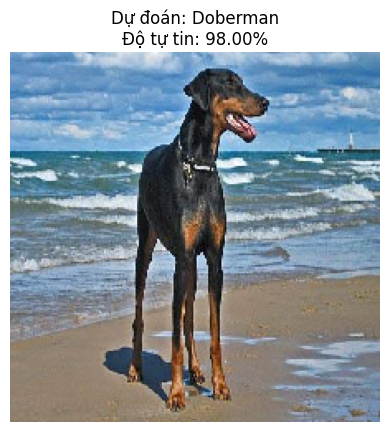

Tiếp tục nhận diện? (y/n): y


Saving n02106166_75.jpg to n02106166_75.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


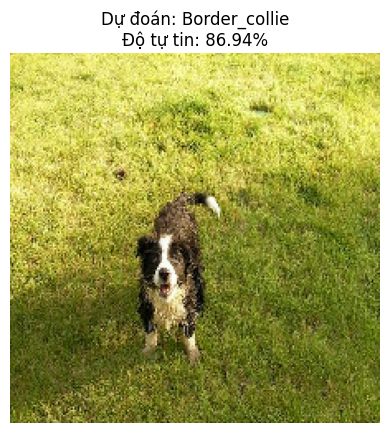

Tiếp tục nhận diện? (y/n): y


Saving n02085620_326.jpg to n02085620_326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


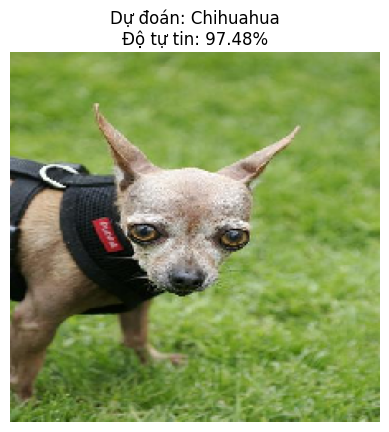

Tiếp tục nhận diện? (y/n): y


Saving n02113799_5486.jpg to n02113799_5486.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


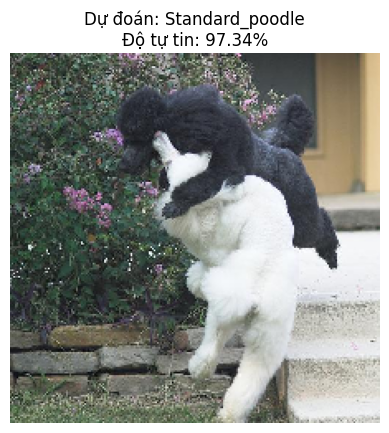

Tiếp tục nhận diện? (y/n): n
Kết thúc!


In [14]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Lấy tên lớp từ train_generator
class_indices = train_generator.class_indices
dog_names = {v: k for k, v in class_indices.items()}  # Đảo ngược ánh xạ

# Hàm để tải lên ảnh và dự đoán
def predict_image():
    while True:
        # Cho phép người dùng tải lên ảnh
        uploaded = files.upload()

        for file_name in uploaded.keys():
            # Load và xử lý ảnh
            img_path = file_name
            img = image.load_img(img_path, target_size=(224, 224))  # Định cỡ ảnh giống như đầu vào của mô hình
            img_array = image.img_to_array(img) / 255.0  # Chuyển đổi ảnh thành array và chuẩn hóa
            img_array = np.expand_dims(img_array, axis=0)  # Thêm chiều batch

            # Dự đoán giống chó
            predictions = model.predict(img_array)
            predicted_class = np.argmax(predictions, axis=1)[0]
            confidence = np.max(predictions) * 100

            # Hiển thị ảnh và kết quả dự đoán
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Dự đoán: {dog_names[predicted_class]}\nĐộ tự tin: {confidence:.2f}%")
            plt.show()

        cont = input("Tiếp tục nhận diện? (y/n): ").strip().lower()
        if cont != 'y':
            print("Kết thúc!")
            break

# Gọi hàm dự đoán
predict_image()
